In [18]:
from sklearn.model_selection import train_test_split
from sklearn import datasets, svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import numpy as np
from math import sqrt
from shapleycomposition import ShapleyExplainer
from composition_stats import ilr, sbp_basis
from bifurc_tree import create_tree_from_sbp, init_graph, build_graph
import plotly.graph_objects as go

In [19]:
K = 10         #Index of the instance you want to test in the test set
N_class = 6    #Number of class, the dimension of the simplex is therefore N_class-1
N_feat  = 6    #In this example, since the number of feature of the digit dataset is quite large (64), we propose to reduce it with a PCA

#load the dataset, take a subset of N_class classes, scale it and split into a training and testing set
X, Y = datasets.load_digits(return_X_y=True)
subset_i = np.where(Y < N_class)
X = X[subset_i]
Y = Y[subset_i]
X = scale(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

#Reduce the number of feature to N_feat with a PCA
pca = PCA(n_components=N_feat)
X_train = pca.fit_transform(X_train)
X_test  = pca.transform(X_test)


#train an SVM classifier
svc_linear = svm.SVC(kernel='rbf', probability=True)
svc_linear.fit(X_train, Y_train)

SVC(probability=True)

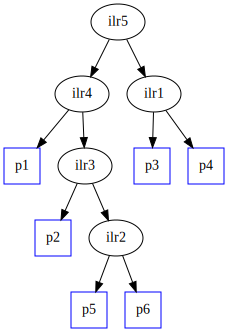

In [20]:
#Choose a sequential binary partition matrix and plot the corresponding bifurcation tree
sbpmatrix = np.array([[1,1,-1,-1,1,1],[1,-1,0,0,-1,-1],[0,1,0,0,-1,-1],[0,0,0,0,1,-1],[0,0,1,-1,0,0]])
basis = np.flip(sbp_basis(sbpmatrix), axis=0)
root = create_tree_from_sbp(sbpmatrix, 6)

##Visualise the tree using graphviz
graph = init_graph()
build_graph(root, graph)
#graph.render('tree.pdf', view=True)
graph       #plot the bifurcation tree


In [21]:

# explain all the predictions in the test set
explainer = ShapleyExplainer(svc_linear.predict_proba, X_train, N_class, sbpmatrix=sbpmatrix)
(shapley, base) = explainer.explain_instance(np.array(X_test[K]))

print("True label of the tested instance: ", end="")
print(Y_test[K])

#get the model prediction for the Kth instance of the test partition
pred = svc_linear.predict_proba(X_test[K].reshape(1,-1))
print("Prediction on the simplex: ",end="")
print(pred)
ilr_pred = ilr(pred, basis=basis)
print("Prediction in the ILR space: ",end="")
print(ilr_pred)

#The sum of the base distribution and the shapley composition in the ILR space is equal to the predicted probability distribution
sum_shap_base = np.array(shapley).sum(axis=0)+base
print("Sum of the shapley composition and the base distribution in the ILR space: ", end="")
print(sum_shap_base)

True label of the tested instance: 2
Prediction on the simplex: [[0.00471314 0.00380993 0.16383614 0.71233937 0.00832478 0.10697664]]
Prediction in the ILR space: [-1.03922612 -1.80550814 -1.68060579 -1.00412497 -3.9418676 ]
Sum of the shapley composition and the base distribution in the ILR space: [-1.0392261  -1.80550814 -1.68060579 -1.00412495 -3.94186762]


In [23]:
#SUMMARIZE WITH NORM, COSINE AND INNER PRODUCTS

(norm_shapley, proj_shap_class, cos_shap_shap) = explainer.summarize()

List of the features sorted by their Shapley strength (norm of their Shapley composition):
	 feature n.1: 2.1592996
	 feature n.2: 1.6740956
	 feature n.3: 1.1594358
	 feature n.5: 0.5113241
	 feature n.4: 0.3775055
	 feature n.6: 0.252566

Cosine between the Shapley compositions and the class vectors:
		feat. n.1 	feat. n.2 	feat. n.3 	feat. n.4 	feat. n.5 	feat. n.6 	
class 1:  	-0.6104727	-0.5203359	-0.4295747	-0.5615601	-0.1519490	-0.7369181	
class 2:  	-0.3149383	-0.2058351	0.0227252	-0.4349373	-0.6935348	0.6273219	
class 3:  	0.3080417	-0.1304446	0.0303544	-0.3243385	0.3077831	0.2783118	
class 4:  	-0.2947952	0.5055213	-0.2159518	0.4004306	0.3531433	0.1925895	
class 5:  	0.2008168	-0.3501340	-0.3330205	0.4037815	0.5715749	0.0237980	
class 6:  	0.7113478	0.7012283	0.9254674	0.5166238	-0.3870175	-0.3851031	

Cosine between each Shapley compositions:
		feat. n.1 	feat. n.2 	feat. n.3 	feat. n.4 	feat. n.5 	feat. n.6 	
feat. n. 1:	1.0000000	0.5181442	0.7662931	0.5920217	0.1178036	0.0

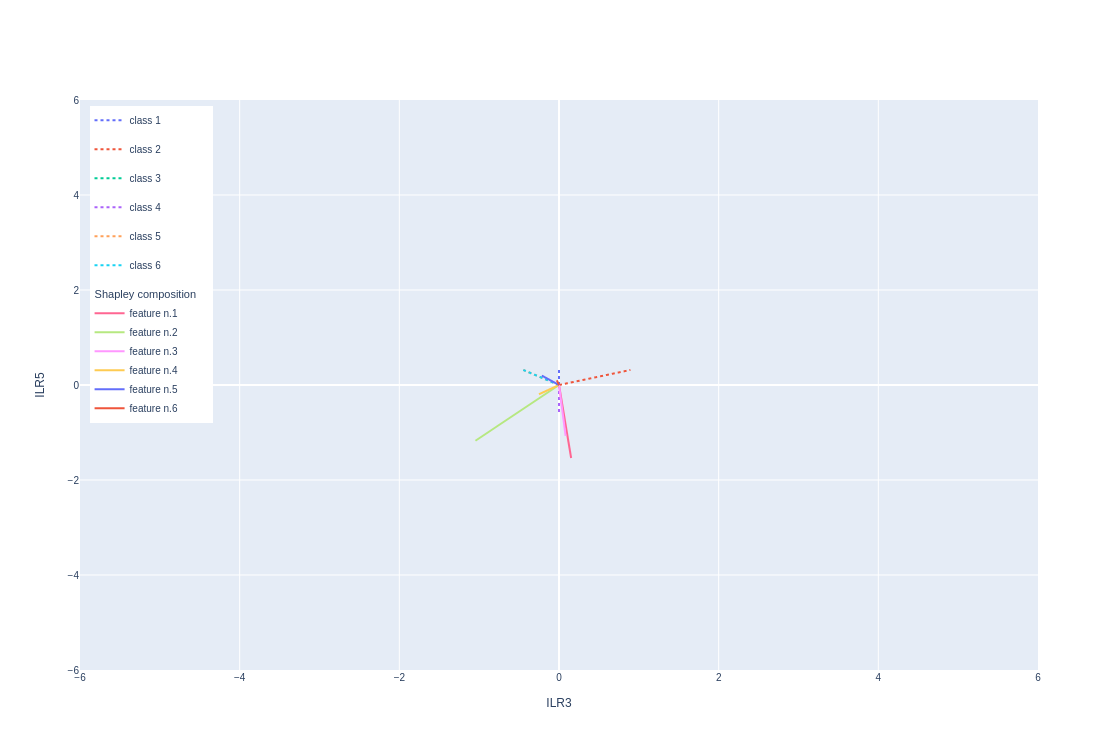

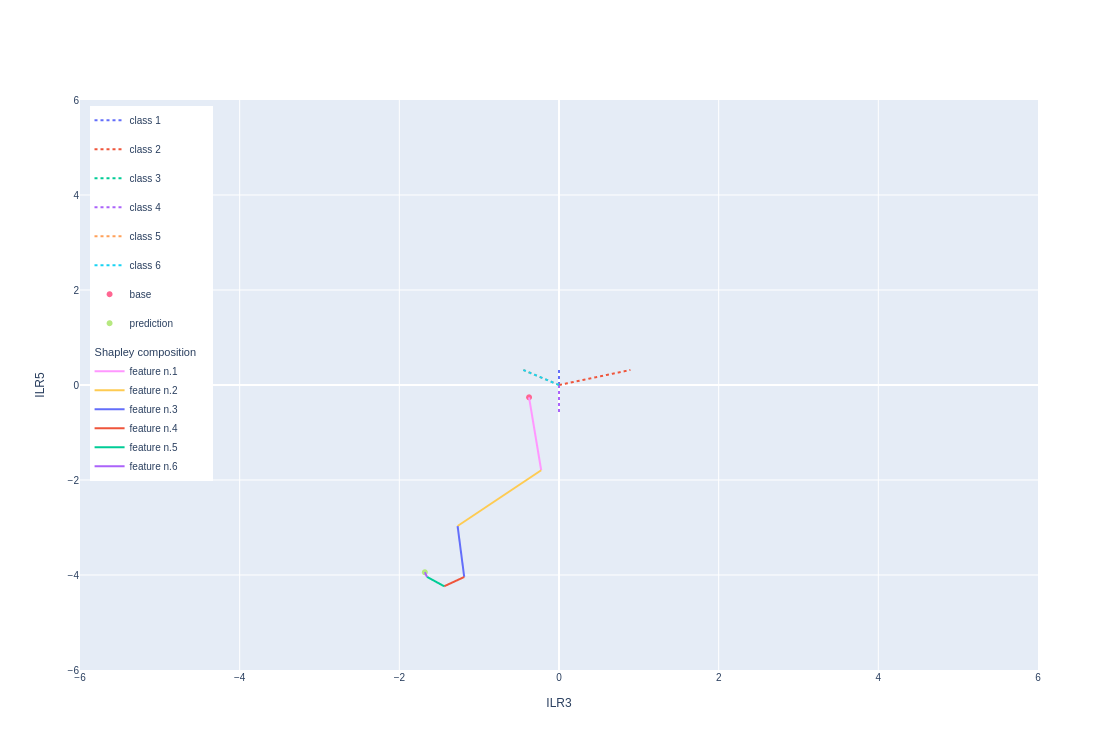

In [24]:
#PLOT the a ILR subspace (corresponding to the chosen ILR components listed in balances).
#plot range [-lim, lim]
#If shapley_sum is True, the sum of the shapley vectors are summed from the base distribution to the prediction

fig = explainer.plot_ilr_space(balances=[3, 5], lim=6, figsize=750)
fig = explainer.plot_ilr_space(balances=[3, 5], shapley_sum=True, lim=6, figsize=750)


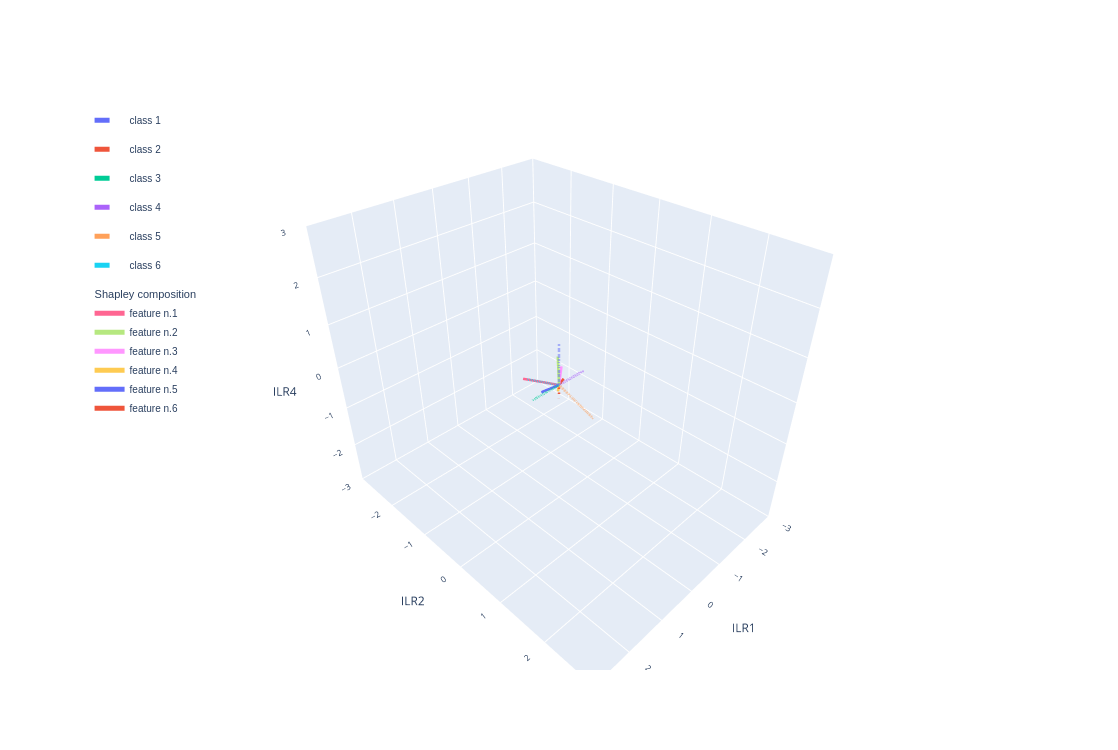

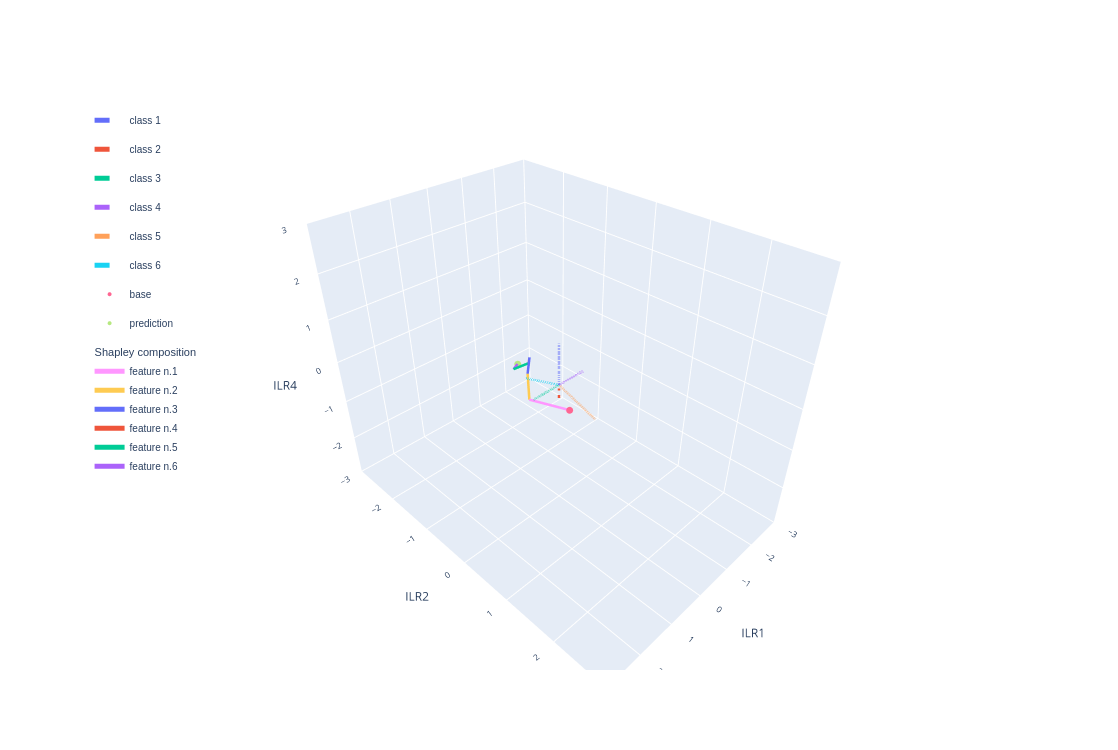

In [25]:
#PLOT the a ILR subspace (corresponding to the chosen ILR components listed in balances).
#plot range [-lim, lim]
#If shapley_sum is True, the sum of the shapley vectors are summed from the base distribution to the prediction

fig = explainer.plot_ilr_space(balances=[1, 2, 4], lim=3, figsize=750)
fig = explainer.plot_ilr_space(balances=[1, 2, 4], shapley_sum=True, lim=3, figsize=750)
